In [53]:
import abc
from datetime import datetime
from uuid import uuid4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('..')


In [54]:
class BaseModel(abc.ABC):
  name: str
  description: str
  
  @abc.abstractmethod
  def serialize(self):
    """Serialize the model to a dictionary"""
    pass
  
  def save(self, filename: str = None):
    """Save the model to a file"""
    if filename is None:
      filename = f"{self.name}_{datetime.now().isoformat()}_{uuid4()}.model"
    
    with open(filename, "w") as f:
      f.write(self.serialize())
  
  @abc.abstractmethod
  def load(self, serialized_model: dict):
    """Load the model from serialized data"""
    pass
  

In [77]:
class SupervisedModel(BaseModel):
  def __init__(self):
    self._ivs = None
    self._dvs = None
    self._is_fitted = False
    
  @abc.abstractmethod
  def fit(self, X, y, *args, **kwargs):
    """Train the model"""
    pass
  
  @abc.abstractmethod
  def predict(self, X):
    """Predict the target variable"""
    pass
  
  @abc.abstractmethod
  def evaluate(self, X, y):
    """Evaluate the model"""
    pass
  
  def set_ivs(self, ivs: pd.DataFrame):
    self._ivs = list(ivs.columns)
  
  def set_dvs(self, dvs: pd.DataFrame | pd.Series):
    if isinstance(dvs, pd.Series):
      self._dvs = [dvs.name]
    else:
      self._dvs = list(dvs.columns)
  
  

In [78]:
df['y'].name

'y'

In [97]:
class ModelNotFittedError(AttributeError):
  def __init__(self, message="Model is not fitted"):
    self.message = message
    super().__init__(self.message)

In [102]:
class OLS(SupervisedModel):
  name = "OLS"
  description = "Ordinary Least Squares"
  
  def __init__(self, intercept: bool = True):
    super().__init__()
    self._coefficients = None
    self._has_intercept = intercept
    
  def serialize(self):
    return {
      "name": self.name,
      "description": self.description
    }
  
  def load(self, serialized_model: dict):
    self.name = serialized_model["name"]
    self.description = serialized_model["description"]
    
  def fit(self, X, y):
    from statsmodels.api import OLS
    self.model = OLS(y, X).fit()
    self._is_fitted = True
    self._coefficients = self.model.params
    self.set_ivs(X)
    self.set_dvs(y)
  
  def summary(self):
    if not self._is_fitted:
      raise ModelNotFittedError()
    return self.model.summary()
  
  def predict(self, X):
    if not self._is_fitted:
      raise ModelNotFittedError()
    
    y_pred = self.model.predict(X)
    return pd.DataFrame(y_pred, columns=self._dvs)
  
  def evaluate(self, X, y):
    if not self._is_fitted:
      raise Exception("Model not fitted")
    
    from sklearn.metrics import mean_squared_error
    y_pred = self.predict(X)
    return mean_squared_error(y, y_pred)
  


In [103]:
my_model = OLS()

In [104]:
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 156)
y = X.dot([0.4, 0.6]) + np.random.normal(0, 1, 156)
data = np.vstack([X.T, y]).T
df = pd.DataFrame(data, columns=["X1", "X2", "y"])
df.corr().style.background_gradient(cmap='coolwarm')

,X1,X2,y
X1,1.000000,0.574176,0.592321
X2,0.574176,1.000000,0.654870
y,0.592321,0.654870,1.000000


In [105]:
my_model.summary()

ModelNotFittedError: Model is not fitted

In [106]:
my_model.fit(df[['X1', 'X2']], df['y'])

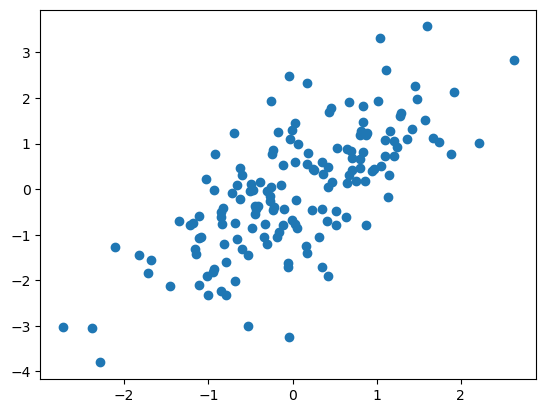

In [107]:
plt.scatter(my_model.predict(df[['X1', 'X2']]), df['y'])